In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = 'w'

This notebook shows an analysis of the Falcon-9 upper stage S-band telemetry frames. It is based on [r00t.cz's analysis](https://www.r00t.cz/Sats/Falcon9).

The frames are CCSDS Reed-Solomon frames with an interleaving depth of 5, a (255,239) code, and an (uncoded) frame size of 1195 bytes.

In [2]:
x = np.fromfile('falcon9_frames_20210324_084608.u8', dtype = 'uint8')
x = x.reshape((-1, 1195))

The first byte of all the frames is `0xe0`. Here we see that one of the frames has an error in this byte.

In [3]:
collections.Counter(x[:,0])

Counter({224: 11132, 124: 1})

The next three bytes form a header composed of a 13 bit frame counter and an 11 bit field that indicates where the first packet inside the payload starts (akin to a first header pointer in CCSDS protocols).

In [4]:
header = np.unpackbits(x[:,1:4], axis = 1)
counter = header[:,:13]
counter = np.concatenate((np.zeros((x.shape[0], 3), dtype = 'uint8'), counter), axis = 1)
counter = np.packbits(counter, axis = 1)
counter = counter.ravel().view('uint16').byteswap()
start_offset = header[:,-11:]
start_offset = np.concatenate((np.zeros((x.shape[0], 5), dtype = 'uint8'), start_offset), axis = 1)
start_offset = np.packbits(start_offset, axis = 1)
start_offset = start_offset.ravel().view('uint16').byteswap()

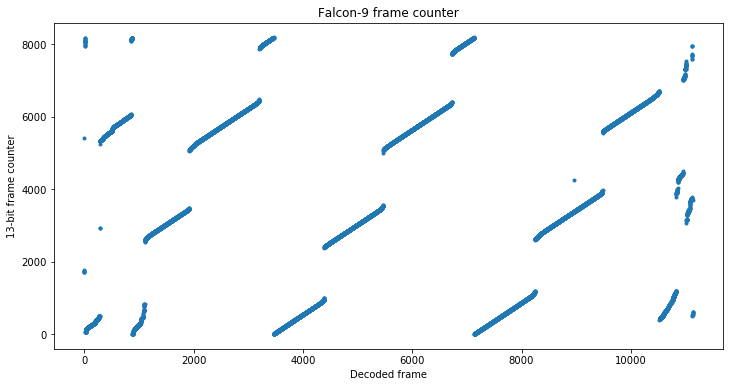

In [5]:
plt.plot(counter, '.')
plt.title('Falcon-9 frame counter')
plt.ylabel('13-bit frame counter')
plt.xlabel('Decoded frame');

Valid packets contain a 2 byte header where the 4 MSBs are set to 1 and the remaining 12 bits indicate the size of the packet payload in bytes (so the total packet size is this value plus 2). Using this header, the packets can be defragmented in the same way as CCSDS Space Packets transmitted using the M_PDU protocol.

In [6]:
def packet_len(packet):
    packet = np.frombuffer(packet[:2], dtype = 'uint8')
    return (packet.view('uint16').byteswap()[0] & 0xfff) + 2

def valid_packet(packet):
    return packet[0] >> 4 == 0xf

def defrag(x, counter, start_offset):
    packet = bytearray()
    frame_count = None
    
    for frame, count, first in zip(x, counter, start_offset):
        frame = frame[4:]
        if frame_count is not None \
          and count != ((frame_count + 1) % 2**13):
            # broken stream
            packet = bytearray()
        frame_count = count

        if first == 0x7fe:
            # only idle
            continue
        elif first == 0x7ff:
            # no packet starts
            if packet:
                packet.extend(frame)
            continue
        
        if packet:
            packet.extend(frame[:first])
            packet = bytes(packet)
            yield packet, frame_count

        while True:
            packet = bytearray(frame[first:][:2])
            if len(packet) < 2:
                # not full header inside frame
                break
            first += 2
            if not valid_packet(packet):
                # padding found
                packet = bytearray()
                break
            length = packet_len(packet) - 2
            packet.extend(frame[first:][:length])
            first += length
            if first > len(frame):
                # packet does not end in this frame
                break
            packet = bytes(packet)
            yield packet, frame_count
            packet = bytearray()
            if first == len(frame):
                # packet just ends in this frame
                break


In [7]:
packets = list(defrag(x, counter, start_offset))

Only ~76% of the frames payload contains packets. The rest is padding.

In [8]:
sum([len(p[0]) for p in packets])/x[:,4:].size

0.7581248567526004

After the 2 byte header, the next 8 bytes of the packet can be used to identify its source or type.

In [9]:
source_ids = [p[0][2:10].hex().upper() for p in packets]
collections.Counter(source_ids)

Counter({'0012420100110C09': 2260,
         '0112520107DC0504': 357,
         '0012620100640C08': 1603,
         '0012420100640C08': 1600,
         '00122201000D0C09': 5668,
         '00124201000D0C09': 5656,
         '00126201000D0C09': 5673,
         '0012620100110C09': 2246,
         '01123201042E1403': 2996,
         '00126201006A0C08': 800,
         '0112520107DB0504': 364,
         '0012620100690C08': 328,
         '0012220100110C09': 2272,
         '0112320107D80504': 1111,
         '0112520107D50504': 2612,
         '00124D0100650108': 310,
         '0012220100150C09': 215,
         '0012620100150C09': 213,
         '0112320107DD0504': 370,
         '0112520107E00504': 183,
         '0112520107E10504': 184,
         '0012420100150C09': 206,
         '0112520107E40504': 125,
         '0017FE08D0440108': 148,
         '0017FE08D0480108': 162,
         '0017FE08D0420108': 163,
         '0012620100650C08': 31,
         '0012620103EE0C08': 31,
         '0012420100650C08': 31,
      

Some packets have 64-bit timestamps starting 3 bytes after the packet source ID. These give nanoseconds since the GPS epoch.

In [10]:
timestamps = np.datetime64('1980-01-06') + \
    np.array([np.frombuffer(p[0][13:][:8], dtype = 'uint64').byteswap()[0] for p in packets]) \
        * np.timedelta64(1, 'ns')
timestamps_valid = (timestamps >= np.datetime64('2021-01-01')) & (timestamps <= np.datetime64('2022-01-01'))

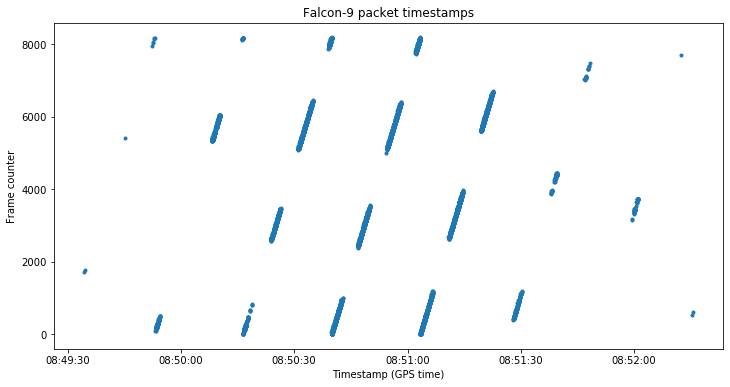

In [11]:
plt.plot(timestamps[timestamps_valid],
         np.array([p[1] for p in packets])[timestamps_valid], '.')
plt.title('Falcon-9 packet timestamps')
plt.xlabel('Timestamp (GPS time)')
plt.ylabel('Frame counter');

### Video packets

Video packets are stored in a particular source ID. If we remove the first 25 and last 2 bytes of these packets, we obtain 5 188-byte transport stream packets.

In [12]:
video_source = '01123201042E1403'
video_packets = [p for p,s in zip(packets, source_ids)
                if s == video_source]
video_ts = bytes().join([p[0][25:-2] for p in video_packets])

Only around 28% of the transmitted data is the transport stream video.

In [13]:
len(video_ts)/sum([len(p[0]) for p in packets])

0.2801592434275875

In [14]:
with open('/tmp/falcon9.ts', 'wb') as f:
    f.write(video_ts)

In [15]:
ts = np.frombuffer(video_ts, dtype = 'uint8').reshape((-1,188))

In [16]:
# sync byte 71 = 0x47
np.unique(ts[:,0])

array([71], dtype=uint8)

In [17]:
# TEI = 0
np.unique(ts[:,1] >> 7)

array([0], dtype=uint8)

In [18]:
pusi = (ts[:,1] >> 6) & 1
# priority = 0
np.unique((ts[:,1] >> 5) & 1)

array([0], dtype=uint8)

In [19]:
pid = ts[:,1:3].ravel().view('uint16').byteswap() & 0x1fff
np.unique(pid)

array([   0,   32,  511, 2748, 4112, 8191], dtype=uint16)

In [20]:
for p in np.unique(pid):
    print(f'PID {p} ratio {np.average(pid == p) * 100:.1f}%')

PID 0 ratio 0.4%
PID 32 ratio 0.4%
PID 511 ratio 6.5%
PID 2748 ratio 11.8%
PID 4112 ratio 79.4%
PID 8191 ratio 1.4%


In [21]:
# TSC = 0
np.unique(ts[:,3] >> 6)

array([0], dtype=uint8)

In [22]:
adaptation = (ts[:,3] >> 4) & 0x3
np.unique(adaptation)

array([1, 2, 3], dtype=uint8)

In [23]:
continuity = ts[:,3] & 0xf

In [24]:
for p in np.unique(pid):
    print('PID', p, 'PUSI values', np.unique(pusi[pid == p]),
          'adaptation field values', np.unique(adaptation[pid == p]))

PID 0 PUSI values [1] adaptation field values [1]
PID 32 PUSI values [1] adaptation field values [1]
PID 511 PUSI values [0] adaptation field values [2]
PID 2748 PUSI values [1] adaptation field values [3]
PID 4112 PUSI values [0 1] adaptation field values [1 3]
PID 8191 PUSI values [0] adaptation field values [1]


In [25]:
pcr_pid = ts[pid == 511]
pcr = np.concatenate((np.zeros((pcr_pid.shape[0], 2), dtype = 'uint8'), pcr_pid[:,6:12]), axis = 1)
pcr = pcr.view('uint64').byteswap().ravel()
pcr_base = pcr >> 15
pcr_extension = pcr & 0x1ff
pcr_value = (pcr_base * 300 + pcr_extension) / 27e6

In [26]:
video_timestamps = timestamps[[s == video_source for s in source_ids]]
ts_timestamps = np.repeat(video_timestamps, 5)
pcr_pid_timestamps = ts_timestamps[pid == 511]

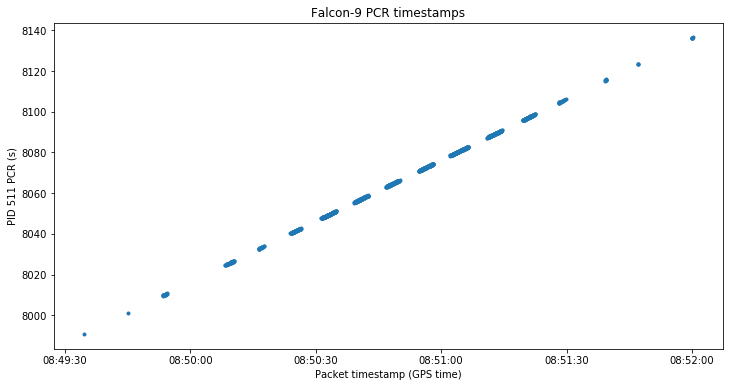

In [27]:
plt.plot(pcr_pid_timestamps, pcr_value, '.')
plt.title('Falcon-9 PCR timestamps')
plt.ylabel('PID 511 PCR (s)')
plt.xlabel('Packet timestamp (GPS time)');

### GPS log

In [28]:
gps_source = '0117FE0800320303'
gps_packets = [p for p,s in zip(packets, source_ids)
                if s == gps_source]

In [29]:
gps_log = ''.join([str(g[0][25:-2], encoding = 'ascii') for g in gps_packets])
with open('/tmp/gps.txt', 'w') as f:
    f.write(gps_log)
print(gps_log)

1300610994400436905> 23 PLL stress
1300611017022690372> Track: [21s 10s 32e 23s 25e 01c 20s  .  .  .  .  .  .  .  .  . | 01s 28s 19s  .611017204400061> Running hot start for sid:5 TOW_ms 291017118!
1300611017204597275> Tracking! PRN:5
1300611026057717790> 1 PLL stress
1300611031677221262> 23 PLL stress
1300611032023066595> Track: [21c 10s 32e 23s 25e 01c 20s  .  .  .  .  .  .  .  .  . | 01s 28s 19s  . 17s  . 23c 13s 24s 12s 05e 15s 21s  . 14s  . ]
1300611032023330905>    dB: [34  42  41  40  38  33  38   .  .  .  .  .  .  .  .  . | 38  44  48   . 48   . 26  48  45  39  36  46  35   . 41   . ]
1300611032215555222> solution x/y/z: 4134817.9 257063.8 5103019.7 PDOP=1.7 n_sats=12
1300611032215837521> solution tow:291031.8257235776, wn:2150
1300611034525282910> 23 PLL stress
1300611039022514132> 23 low CN0 too long, dropping (@ 103712228202000000.000)
1300611040045135624> Tracking! PRN:6
1300611040049727411> Found 6 over 120.0 kHz in 351 ms, CN0:37.2 dB
1300611042023334560> Track: [21c 10s 